In [1]:
import keras

Using TensorFlow backend.


In [2]:
from keras import backend as K

cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [3]:
from keras.layers import Conv2DTranspose ,concatenate, Input,Activation ,Conv2D ,BatchNormalization , Dense ,Dropout ,Flatten ,MaxPool2D ,GlobalMaxPool2D ,GlobalAveragePooling2D
from keras.models import Sequential ,Model
from keras.optimizers import Adam

In [4]:
import keras.backend as K
import tensorflow as tf
from keras.layers import *

def resize_images_bilinear(X, height_factor=1, width_factor=1, target_height=None, target_width=None, data_format='default'):
    '''Resizes the images contained in a 4D tensor of shape
    - [batch, channels, height, width] (for 'channels_first' data_format)
    - [batch, height, width, channels] (for 'channels_last' data_format)
    by a factor of (height_factor, width_factor). Both factors should be
    positive integers.
    '''
    if data_format == 'default':
        data_format = K.image_data_format()
    if data_format == 'channels_first':
        original_shape = K.int_shape(X)
        if target_height and target_width:
            new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
        else:
            new_shape = tf.shape(X)[2:]
            new_shape *= tf.constant(np.array([height_factor, width_factor]).astype('int32'))
        X = permute_dimensions(X, [0, 2, 3, 1])
        X = tf.image.resize_bilinear(X, new_shape)
        X = permute_dimensions(X, [0, 3, 1, 2])
        if target_height and target_width:
            X.set_shape((None, None, target_height, target_width))
        else:
            X.set_shape((None, None, original_shape[2] * height_factor, original_shape[3] * width_factor))
        return X
    elif data_format == 'channels_last':
        original_shape = K.int_shape(X)
        if target_height and target_width:
            new_shape = tf.constant(np.array((target_height, target_width)).astype('int32'))
        else:
            new_shape = tf.shape(X)[1:3]
            new_shape *= tf.constant(np.array([height_factor, width_factor]).astype('int32'))
        X = tf.image.resize_bilinear(X, new_shape)
        if target_height and target_width:
            X.set_shape((None, target_height, target_width, None))
        else:
            X.set_shape((None, original_shape[1] * height_factor, original_shape[2] * width_factor, None))
        return X
    else:
        raise Exception('Invalid data_format: ' + data_format)

class BilinearUpSampling2D(Layer):
    def __init__(self, size=(1, 1), target_size=None, data_format='default', **kwargs):
        if data_format == 'default':
            data_format = K.image_data_format()
        self.size = tuple(size)
        if target_size is not None:
            self.target_size = tuple(target_size)
        else:
            self.target_size = None
        assert data_format in {'channels_last', 'channels_first'}, 'data_format must be in {tf, th}'
        self.data_format = data_format
        self.input_spec = [InputSpec(ndim=4)]
        super(BilinearUpSampling2D, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            width = int(self.size[0] * input_shape[2] if input_shape[2] is not None else None)
            height = int(self.size[1] * input_shape[3] if input_shape[3] is not None else None)
            if self.target_size is not None:
                width = self.target_size[0]
                height = self.target_size[1]
            return (input_shape[0],
                    input_shape[1],
                    width,
                    height)
        elif self.data_format == 'channels_last':
            width = int(self.size[0] * input_shape[1] if input_shape[1] is not None else None)
            height = int(self.size[1] * input_shape[2] if input_shape[2] is not None else None)
            if self.target_size is not None:
                width = self.target_size[0]
                height = self.target_size[1]
            return (input_shape[0],
                    width,
                    height,
                    input_shape[3])
        else:
            raise Exception('Invalid data_format: ' + self.data_format)

    def call(self, x, mask=None):
        if self.target_size is not None:
            return resize_images_bilinear(x, target_height=self.target_size[0], target_width=self.target_size[1], data_format=self.data_format)
        else:
            return resize_images_bilinear(x, height_factor=self.size[0], width_factor=self.size[1], data_format=self.data_format)

    def get_config(self):
        config = {'size': self.size, 'target_size': self.target_size}
        base_config = super(BilinearUpSampling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
import os
def FCN_Vgg16_32s( weight_decay=0,classes=4):
    img_input = Input(shape=(224,224,3))
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', kernel_regularizer=l2(weight_decay))(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', kernel_regularizer=l2(weight_decay))(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Convolutional layers transfered from fully-connected layers
    x = Conv2D(4096, (7, 7), activation='relu', padding='same', name='fc1', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    x = Conv2D(4096, (1, 1), activation='relu', padding='same', name='fc2', kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.5)(x)
    #classifying layer
    x = Conv2D(classes, (1, 1), kernel_initializer='he_normal', activation='linear', padding='valid', strides=(1, 1), kernel_regularizer=l2(weight_decay))(x)

    x = BilinearUpSampling2D(size=(32, 32))(x)

    model = Model(img_input, x)

   
    return model

In [6]:
model=FCN_Vgg16_32s()

NameError: name 'l2' is not defined

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [42]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
gen=image.ImageDataGenerator( rotation_range=15,shear_range=0.1 ,channel_shift_range=0.2 ,width_shift_range=0.4 , height_shift_range=0.25)
gen1=image.ImageDataGenerator()

In [58]:
batch_size=30

train= gen.flow_from_directory('train', target_size=(224,224),
                class_mode='categorical', shuffle=True, batch_size=batch_size )

Found 5820 images belonging to 4 classes.


In [59]:
val= gen1.flow_from_directory('val', target_size=(224,224),
                class_mode='categorical', shuffle=False, batch_size=batch_size )

Found 1098 images belonging to 4 classes.


In [53]:
from keras.optimizers import Adam
model.compile(Adam(lr=0.00001), loss=loss_fn, metrics=metrics)

In [49]:
def sparse_accuracy_ignoring_last_label(y_true, y_pred):
    nb_classes = K.int_shape(y_pred)[-1]
    y_pred = K.reshape(y_pred, (-1, nb_classes))

    y_true = K.one_hot(tf.to_int32(K.flatten(y_true)),
                       nb_classes + 1)
    unpacked = tf.unstack(y_true, axis=-1)
    legal_labels = ~tf.cast(unpacked[-1], tf.bool)
    y_true = tf.stack(unpacked[:-1], axis=-1)

    return K.sum(tf.to_float(legal_labels & K.equal(K.argmax(y_true, axis=-1), K.argmax(y_pred, axis=-1)))) / K.sum(tf.to_float(legal_labels))

In [51]:
def softmax_sparse_crossentropy_ignoring_last_label(y_true, y_pred):
    y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
    log_softmax = tf.nn.log_softmax(y_pred)

    y_true = K.one_hot(tf.to_int32(K.flatten(y_true)), K.int_shape(y_pred)[-1]+1)
    unpacked = tf.unstack(y_true, axis=-1)
    y_true = tf.stack(unpacked[:-1], axis=-1)

    cross_entropy = -K.sum(y_true * log_softmax, axis=1)
    cross_entropy_mean = K.mean(cross_entropy)

    return cross_entropy_mean


In [52]:
target_size=None
batchnorm_momentum=0.9
          
resume_training=False 
class_weight=None
          
loss_fn = softmax_sparse_crossentropy_ignoring_last_label
metrics = [sparse_accuracy_ignoring_last_label]
loss_shape=None
label_suffix='.png'
data_suffix='.jpg'
ignore_label=255
label_cval=255

In [54]:
batch_size=30
model.fit_generator(train, steps_per_epoch=5820/batch_size, epochs=3, 
                            validation_data=val, validation_steps=1098/batch_size,)

Epoch 1/3


ValueError: Cannot feed value of shape (30, 4) for Tensor 'bilinear_up_sampling2d_4_target_1:0', which has shape '(?, ?, ?, ?)'

In [ ]:

model.optimizer.lr=0.1
for i in range (1,3):
    model.fit_generator(train, steps_per_epoch=2387/batch_size, epochs=5, 
                            validation_data=val, validation_steps=594/batch_size)
    model.save_weights ('fcnn_lap{x}.h5'.format(x=i))

Epoch 1/5
80/79 [==============================] - 177s - loss: 1.2178 - acc: 0.4533 - val_loss: 1.3469 - val_acc: 0.2017
Epoch 2/5
27/79 [=========>....................] - ETA: 85s - loss: 1.2006 - acc: 0.4617

In [502]:
model.optimizer.lr=0.01
for i in range (3,5):
    model.fit_generator(train, steps_per_epoch=2387/batch_size, epochs=5, 
                            validation_data=val, validation_steps=594/batch_size)
    model.save_weights ('fcnn_lap{x}.h5'.format(x=i))

Epoch 1/5
79/79 [============================>.] - ETA: 0s - loss: 0.1194 - acc: 0.9582

KeyboardInterrupt: 

In [ ]:
model.optimizer.lr=0.001
for i in range (5,7):
    model.fit_generator(train, steps_per_epoch=2387/batch_size, epochs=5, 
                            validation_data=val, validation_steps=594/batch_size)
    model.save_weights ('fcnn_lap{x}.h5'.format(x=i))

In [ ]:
model.optimizer.lr=0.0001
for i in range (10,13):
    model.fit_generator(train, steps_per_epoch=2387/batch_size, epochs=5, 
                            validation_data=val, validation_steps=594/batch_size)
    model.save_weights ('fcnn_{x}.h5'.format(x=i))

Epoch 1/5
80/79 [==============================] - 132s - loss: 0.1791 - acc: 0.9320 - val_loss: 0.1616 - val_acc: 0.9444
Epoch 2/5
80/79 [==============================] - 131s - loss: 0.1635 - acc: 0.9380 - val_loss: 0.1356 - val_acc: 0.9562
Epoch 3/5
80/79 [==============================] - 131s - loss: 0.1599 - acc: 0.9393 - val_loss: 0.1509 - val_acc: 0.9444
Epoch 4/5
80/79 [==============================] - 131s - loss: 0.1643 - acc: 0.9385 - val_loss: 0.1532 - val_acc: 0.9512
Epoch 5/5
80/79 [==============================] - 131s - loss: 0.1557 - acc: 0.9397 - val_loss: 0.1613 - val_acc: 0.9411
Epoch 1/5
80/79 [==============================] - 132s - loss: 0.1541 - acc: 0.9467 - val_loss: 0.1319 - val_acc: 0.9512
Epoch 2/5
80/79 [==============================] - 131s - loss: 0.1548 - acc: 0.9384 - val_loss: 0.1281 - val_acc: 0.9512
Epoch 3/5
80/79 [==============================] - 131s - loss: 0.1538 - acc: 0.9401 - val_loss: 0.1737 - val_acc: 0.9343
Epoch 4/5
80/79 [=======

In [ ]:
model.optimizer.lr=0.00001
for i in range (13,16):
    model.fit_generator(train, steps_per_epoch=2387/batch_size, epochs=5, 
                            validation_data=val, validation_steps=594/batch_size)
    model.save_weights ('fcnn_{x}.h5'.format(x=i))

In [ ]:
model.optimizer.lr=0.001
model.fit_generator(train, steps_per_epoch=2387/batch_size, epochs=5, 
                            validation_data=val, validation_steps=594/batch_size)
model.save_weights ('fcnn5.h5')

In [ ]:

model.fit_generator(train, steps_per_epoch=2387/batch_size, epochs=5, 
                            validation_data=val, validation_steps=594/batch_size)
model.save_weights ('fcnn6.h5')

In [ ]:
model.optimizer.lr=0.0001
for i in range (7,17):
    model.fit_generator(train, steps_per_epoch=2387/batch_size, epochs=1, 
                            validation_data=val, validation_steps=594/batch_size)
    model.save_weights ('fcnn{x}.h5'.format(x=i))

In [ ]:

model.fit_generator(train, steps_per_epoch=2387/batch_size, epochs=1, 
                            validation_data=val, validation_steps=594/batch_size)

In [12]:
model.load_weights ('unet29.h5')

In [11]:
test = gen1.flow_from_directory('test', target_size=(160,320),
                class_mode='categorical', shuffle=False, batch_size=1, color_mode='grayscale' )

Found 200 images belonging to 4 classes.


In [14]:
pre=model.predict_generator(test,200)

In [12]:
files = test.filenames

In [16]:
test.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [17]:
mistake=0
doubt=0
file=[]
file1=[]
correct=0
num=0
for x in pre : 
    
    if (x[0]<0.5 and x[0]>0.3) or (x[1]<0.5 and x[1]>0.3) or (x[2]<0.5 and x[2]>0.3) or (x[3]<0.5 and x[3]>0.3)  : 
        doubt+=1
        print (x , "doubt")
        file1.append (files[num])
    else:
        if num<50:
            if x[0]<0.3: 
                mistake+=1
                print (x,num)
                file.append (files[num])
            else : correct+=1
        elif num<100:
            if x[1]<0.3: 
                mistake+=1
                print (x,num) 
                file.append (files[num])
            else : correct+=1
        elif num<150:
            if x[2]<0.3: 
                mistake+=1
                print (x,num) 
                file.append (files[num])
            else : correct+=1
                
        else:
            if x[3]<0.3: 
                mistake+=1
                print (x,num) 
                file.append (files[num])
            else : correct+=1
    num+=1
    
all=correct+mistake

[ 0.25013334  0.0508466   0.40439543  0.29462466] doubt
[ 0.28155985  0.05602573  0.43135494  0.23105948] doubt
[ 0.24664074  0.05058913  0.38594162  0.31682852] doubt
[ 0.03621495  0.04618841  0.04356539  0.87403131] 3
[ 0.26895648  0.07411563  0.42175689  0.23517095] doubt
[ 0.26919207  0.06465197  0.46760321  0.19855276] doubt
[ 0.27152196  0.0615747   0.48177275  0.18513052] doubt
[ 0.01535744  0.09030143  0.01891134  0.87542975] 7
[ 0.02030812  0.07647724  0.02420316  0.87901151] 8
[ 0.25293919  0.04675898  0.40245903  0.29784283] doubt
[ 0.27617189  0.05741526  0.48256341  0.18384947] doubt
[ 0.01547058  0.04276614  0.01679599  0.92496729] 11
[ 0.02539779  0.0734317   0.03152557  0.86964494] 12
[ 0.28207767  0.04999023  0.49816686  0.16976522] doubt
[ 0.28229156  0.04742266  0.5066058   0.16367997] 14
[ 0.0468628   0.08496349  0.05287576  0.81529796] 15
[ 0.27775788  0.05908011  0.48416758  0.17899448] doubt
[ 0.3024843   0.0818787   0.39069369  0.22494319] doubt
[ 0.27018878  0.

In [18]:
correct/all

0.34782608695652173

In [19]:
doubt/(all+doubt)

0.54

In [20]:
mistake

60

In [21]:
test.class_indices

{'al': 0, 'bl': 1, 'lotr': 2, 'ra': 3}

In [22]:
image.array_to_img (test[109])

TypeError: 'DirectoryIterator' object does not support indexing

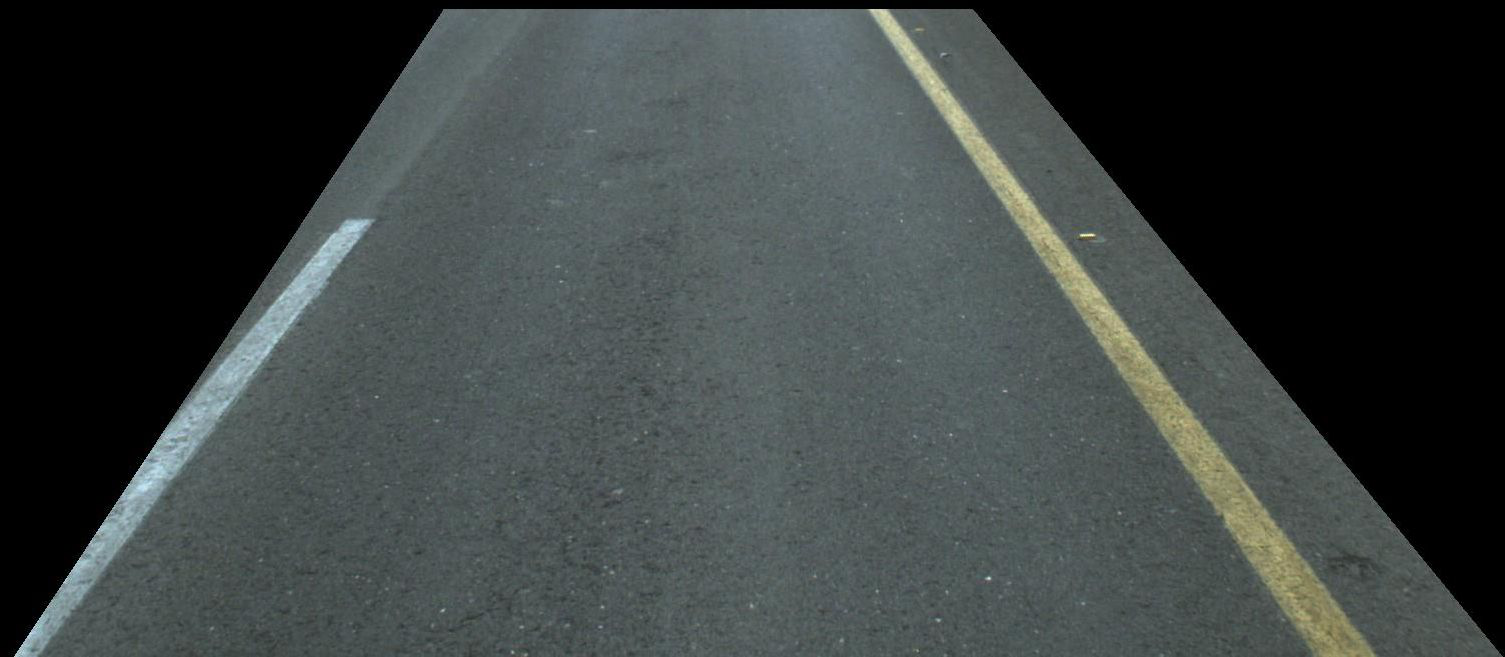

In [23]:
image.load_img ('test/'+files[151])

In [24]:
test = gen.flow_from_directory('test', target_size=(160,320),
                class_mode='categorical', shuffle=False, batch_size=1 )

Found 200 images belonging to 4 classes.


In [25]:
from matplotlib import pyplot as plt

def plot(img):
    plt.imshow(to_plot(img))


def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

In [26]:
%matplotlib inline

In [27]:
import numpy as np
train = gen1.flow_from_directory('train', target_size=(160,320),
                class_mode=None, shuffle=False, batch_size=1 ,color_mode='grayscale' )
train1=np.concatenate([train.next() for i in range(train.samples)])
val = gen1.flow_from_directory('val', target_size=(160,320),
                class_mode=None, shuffle=False, batch_size=1,color_mode='grayscale'  )
val1=np.concatenate([val.next() for i in range(val.samples)])

Found 5820 images belonging to 4 classes.
Found 1098 images belonging to 4 classes.


In [28]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [138]:
save_array ('train1.bc',train1)

In [139]:
save_array ('val1.bc',val1)

In [29]:
train1=load_array ('train1.bc')

In [30]:
train1.shape

(5820, 160, 320, 1)

In [31]:
val1=load_array ('val1.bc')

In [32]:
test = gen1.flow_from_directory('test', target_size=(160,320),
                class_mode=None, shuffle=False, batch_size=1 ,color_mode='grayscale' )


import numpy as np
test1=np.concatenate([test.next() for i in range(test.samples)])


Found 200 images belonging to 4 classes.


In [33]:
from PIL import Image as img

In [34]:
x1= img.open ('test/'+files[15]).convert("L")
x2= img.open ('test/'+files[58]).convert("L")
x3= img.open ('test/'+files[112]).convert("L")
x4= img.open ('test/'+files[151]).convert("L")
arr1 = np.asarray(x1)
arr2 = np.asarray(x2)
arr3 = np.asarray(x3)
arr4 = np.asarray(x4)

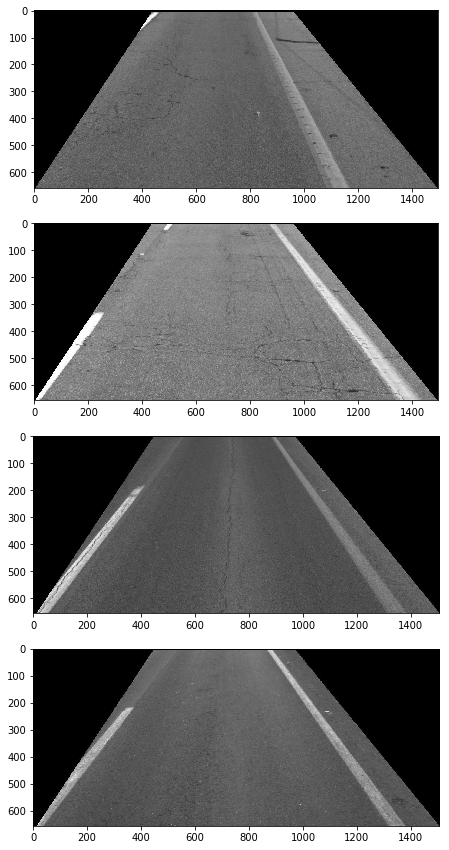

In [35]:
plt.subplots(figsize=(15, 15))
plt.subplot(4, 1, 1 )
plt.imshow(arr1, cmap='gray')
plt.subplot(4, 1, 2 )
plt.imshow(arr2, cmap='gray')
plt.subplot(4, 1, 3 )
plt.imshow(arr3, cmap='gray')
plt.subplot(4, 1, 4 )
plt.imshow(arr4, cmap='gray')

In [36]:
al=test1[15]
bl=test1[58]
lotr=test1[112]
ra=test1[151]


In [37]:
from keras import backend as K
l =model.layers
conv_fn = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[-4].output])

In [38]:
inp = np.expand_dims(al, 0)
conv = conv_fn([inp,0])
conv=conv[0]

show=np.swapaxes(conv,2,3)
show=np.swapaxes(show,1,2)
show1=show[0]
    
inp = np.expand_dims(bl, 0)
conv = conv_fn([inp,0])
conv=conv[0]

show=np.swapaxes(conv,2,3)
show=np.swapaxes(show,1,2)
show2=show[0]

inp = np.expand_dims(lotr, 0)
conv = conv_fn([inp,0])
conv=conv[0]

show=np.swapaxes(conv,2,3)
show=np.swapaxes(show,1,2)
show3=show[0]


inp = np.expand_dims(ra, 0)
conv = conv_fn([inp,0])
conv=conv[0]

show=np.swapaxes(conv,2,3)
show=np.swapaxes(show,1,2)
show4=show[0]
    

In [39]:
show3.shape

(32, 160, 320)

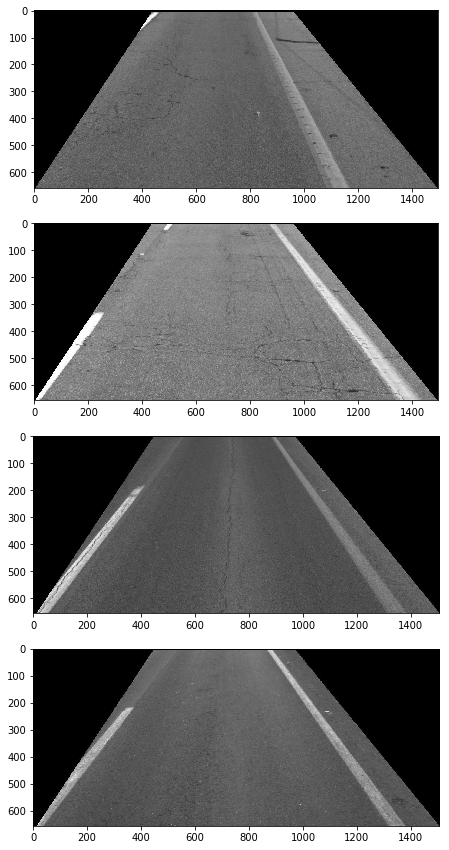

In [40]:
plt.subplots(figsize=(15, 15))
plt.subplot(4, 1, 1 )
plt.imshow(arr1, cmap='gray')
plt.subplot(4, 1, 2 )
plt.imshow(arr2, cmap='gray')
plt.subplot(4, 1, 3 )
plt.imshow(arr3, cmap='gray')
plt.subplot(4, 1, 4 )
plt.imshow(arr4, cmap='gray')

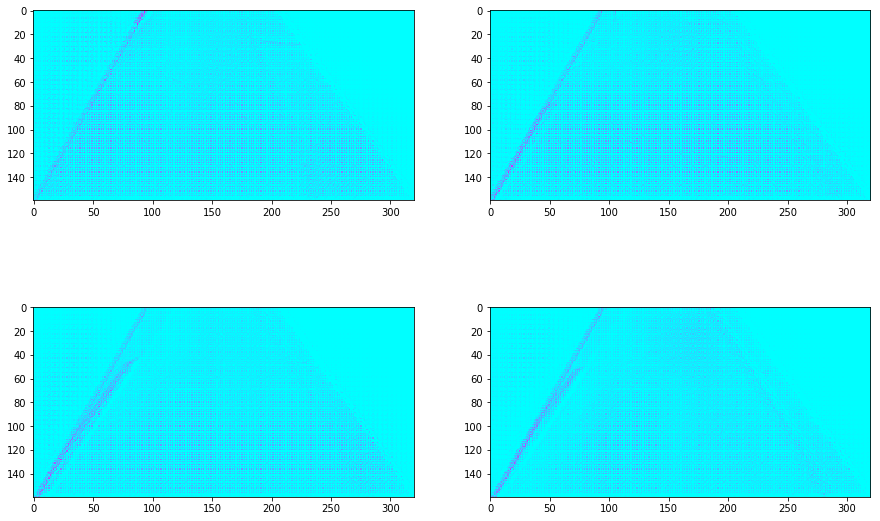

In [41]:
num=31
plt.subplots(figsize=(15, 10))

plt.subplot(2, 2, 1 )
plt.imshow (show1[num] , cmap="cool") 
plt.subplot(2, 2, 2 )
plt.imshow (show2[num] , cmap="cool") 
plt.subplot(2, 2, 3 )
plt.imshow (show3[num] , cmap="cool") 
plt.subplot(2, 2, 4 )
plt.imshow (show4[num] , cmap="cool") 


In [ ]:
al=test1[15]
bl=test1[58]
lotr=test1[112]
ra=test1[151]

In [39]:
img = cv2.imread('test/'+files[58],0)
laplacian = cv2.Laplacian(img,cv2.CV_64F)

In [45]:
laplacian.shape

(657, 1497)

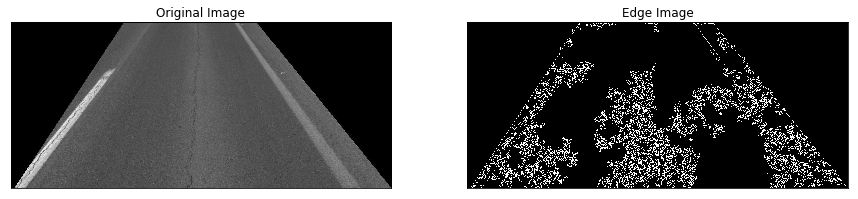

In [59]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('test/'+files[112],0)

edges = cv2.Canny(img,5,150)
plt.subplots(figsize=(15, 10))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [42]:
newtrain=[]
for pic in range (0,5820,2):
    inp = np.expand_dims(train1[pic], 0)
    conv = conv_fn([inp,0])
    conv=conv[0]

    show=np.swapaxes(conv,2,3)
    show=np.swapaxes(show,1,2)
    show=show[0]
    
    x=[]
  
    x.append (show[7])
    x.append (show[10])
    x.append (show[12])
    x.append (show[13])
    x.append (show[22])
   
    newtrain.append(x)


In [35]:
save_array ('newtrain.bc',newtrain)

In [43]:
newtrain=np.array(newtrain)

In [ ]:
train2=np.concatenate([newtrain[i] for i in range(5820)])

In [44]:
newtrain.shape

(2910, 5, 160, 320)

In [45]:
newval=[]
for pic in range (1098):
    inp = np.expand_dims(val1[pic], 0)
    conv = conv_fn([inp,0])
    conv=conv[0]

    show=np.swapaxes(conv,2,3)
    show=np.swapaxes(show,1,2)
    show=show[0]
    
    x=[]
    x.append (show[7])
    x.append (show[10])
    x.append (show[12])
    x.append (show[13])
    x.append (show[22])
   
    newval.append(x)

In [46]:
newval=np.array(newval)

In [47]:
newval.shape

(1098, 5, 160, 320)

In [48]:
newtest=[]
for pic in range (200):
    inp = np.expand_dims(test1[pic], 0)
    conv = conv_fn([inp,0])
    conv=conv[0]

    show=np.swapaxes(conv,2,3)
    show=np.swapaxes(show,1,2)
    show=show[0]
    
    x=[]
  
    x.append (show[7])
    x.append (show[10])
    x.append (show[12])
    x.append (show[13])
    x.append (show[22])
   
    newtest.append(x)

In [49]:
newtest=np.array(newtest)

In [50]:
newtest.shape

(200, 5, 160, 320)

In [57]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

val_classes = val.classes
trn_classes = train.classes[::2]
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [58]:
trn_labels.shape

(2910, 4)

In [66]:
model1 = Sequential([
    
    Flatten(input_shape = (5, 160, 320)),
    Dense(1000, activation='relu'),
    Dropout (0.5),
    Dense(1000, activation='relu'),
      Dropout (0.5),
    Dense(4, activation='softmax' )
    ])

In [67]:
from keras.optimizers import Adam ,SGD ,Adamax ,RMSprop
model1.compile(Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
model1.fit (newtrain,trn_labels , batch_size=50 , epochs=20, shuffle=True , validation_data= (newval,val_labels))

Train on 2910 samples, validate on 1098 samples
Epoch 1/20
2910/2910 [==============================] - 10s - loss: 5.5984 - acc: 0.4182 - val_loss: 5.4640 - val_acc: 0.2878
Epoch 2/20
2910/2910 [==============================] - 7s - loss: 2.3980 - acc: 0.4323 - val_loss: 1.5824 - val_acc: 0.2732
Epoch 3/20
2910/2910 [==============================] - 7s - loss: 1.3027 - acc: 0.4162 - val_loss: 1.5442 - val_acc: 0.3452
Epoch 4/20
2910/2910 [==============================] - 7s - loss: 1.2527 - acc: 0.4254 - val_loss: 1.5824 - val_acc: 0.2878
Epoch 5/20
2910/2910 [==============================] - 7s - loss: 1.2848 - acc: 0.4306 - val_loss: 1.5028 - val_acc: 0.2805
Epoch 6/20
2910/2910 [==============================] - 7s - loss: 1.2658 - acc: 0.4364 - val_loss: 1.5180 - val_acc: 0.3015
Epoch 7/20
2910/2910 [==============================] - 7s - loss: 1.2502 - acc: 0.4471 - val_loss: 1.5171 - val_acc: 0.2741
Epoch 8/20
2910/2910 [==============================] - 7s - loss: 1.2462 - 

In [ ]:
model.optimizer.lr=0.01
model1.fit (newtrain,trn_labels , batch_size=50 , epochs=20, shuffle=True , validation_data= (newval,val_labels))

Train on 2910 samples, validate on 1098 samples
Epoch 1/20
2910/2910 [==============================] - 15s - loss: 1.1367 - acc: 0.4704 - val_loss: 1.4283 - val_acc: 0.2878
Epoch 2/20
2910/2910 [==============================] - 15s - loss: 1.1068 - acc: 0.5003 - val_loss: 1.4887 - val_acc: 0.3306
Epoch 3/20
2910/2910 [==============================] - 7s - loss: 1.1054 - acc: 0.4911 - val_loss: 1.5139 - val_acc: 0.3179
Epoch 4/20
2910/2910 [==============================] - 7s - loss: 1.0998 - acc: 0.4979 - val_loss: 1.5246 - val_acc: 0.3197
Epoch 5/20
2910/2910 [==============================] - 7s - loss: 1.0927 - acc: 0.5058 - val_loss: 1.4558 - val_acc: 0.3179
Epoch 6/20
2910/2910 [==============================] - 7s - loss: 1.0911 - acc: 0.5131 - val_loss: 1.5260 - val_acc: 0.2933
Epoch 7/20
2910/2910 [==============================] - 7s - loss: 1.0974 - acc: 0.5010 - val_loss: 1.4390 - val_acc: 0.3352
Epoch 8/20
2910/2910 [==============================] - 7s - loss: 1.1049 -

In [803]:
pre= model1.predict (newtest2)

In [804]:
mistake=0
doubt=0
file=[]
file1=[]
correct=0
num=0
for x in pre :
    
    if x[0]<0.8 and x[0]>0.2: 
        doubt+=1
        print (x , "doubt" )
       
    else:
        if num<0:
            if x[0]<0.8: 
                mistake+=1
                print (x,num)
               
            else : 
                correct+=1
        else:
            if x[1]<0.8: 
                mistake+=1
                print (x,num) 
               
            else : 
                correct+=1
    num+=1
    
all=correct+mistake

[ 0.36476666  0.63523334] doubt
[ 0.66995203  0.33004797] doubt
[ 0.61969554  0.38030449] doubt
[ 0.27058876  0.72941124] doubt
[  9.99982715e-01   1.73311819e-05] 4
[ 0.69527799  0.30472204] doubt
[ 0.73551303  0.26448691] doubt
[  1.00000000e+00   3.85549839e-12] 7
[  1.00000000e+00   8.67305602e-11] 8
[ 0.35482085  0.64517915] doubt
[  1.00000000e+00   8.20368426e-12] 10
[ 0.72045451  0.27954543] doubt
[ 0.98629749  0.01370249] 12
[  9.99999642e-01   3.05395019e-07] 13
[  1.00000000e+00   1.99483718e-09] 14
[  1.00000000e+00   3.75080522e-10] 15
[ 0.71231091  0.28768903] doubt
[ 0.70043093  0.2995691 ] doubt
[ 0.9883309   0.01166907] 18
[ 0.83161318  0.16838676] 19
[  1.00000000e+00   2.13850040e-08] 20
[ 0.30405587  0.69594407] doubt
[  1.00000000e+00   1.48065032e-10] 22
[ 0.28854725  0.71145272] doubt
[ 0.99413472  0.00586528] 24
[  1.00000000e+00   2.14086422e-11] 25
[  1.00000000e+00   5.47328112e-12] 26
[ 0.7174449   0.28255516] doubt
[  1.00000000e+00   1.20785004e-09] 28
[  

In [805]:
print (correct/all ,"correct")
print (doubt/(all+doubt), "doubt")
print  (mistake , "mistake")

0.011111111111111112 correct
0.21739130434782608 doubt
89 mistake
